# XAI Laboratory 01 - Tabular Methods

For this practice, you will need the following dataset:

- **fifa**: regression dataset containing FIFA players data:
    - short_name: name of the player
    - nationality
    - overall: overall score of the player (potential output)
    - potential: potential score of the player (potential output)
    - wage_eur: contract cancellation fine of the player (potential output)
    - value_eur: value in euros of the player (potential output)
    - age: age of the player in years
    - height_cm: height of the player in cm
    - weight_kg: weight of the player in kg
    - attacking_skills: several variables related to attacking
    - defending_skills: several variables related to defending
    - goalkeeping_skills: several variables related to goalkeeping

Use what you have learned from the `tabular_explanation.ipynb` notebook to complete the questions.

In [27]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# XAI
import shap
import lime
from alepython import ale_plot # You might need to install from source: pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(2025)

In [28]:
### Load file --------------------------------------------
df = pd.read_csv('../data/fifa.csv')
df.head()

,short_name,nationality,overall,potential,wage_eur,value_eur,age,height_cm,weight_kg,attacking_crossing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,Argentina,94,94,565000,95500000,32,170,72,88,...,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,Portugal,93,93,405000,58500000,34,187,83,84,...,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,Brazil,92,92,290000,105500000,27,175,68,87,...,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,Slovenia,91,93,125000,77500000,26,188,87,13,...,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,Belgium,91,91,470000,90000000,28,175,74,81,...,88,91,34,27,22,11,12,6,8,8


In [29]:
X = df.drop(["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"], axis = 1)
y = df['value_eur']

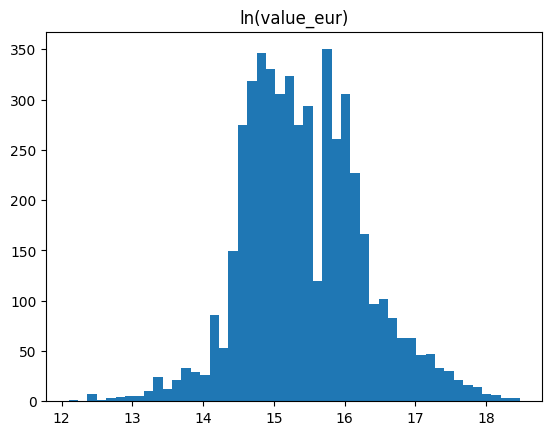

In [30]:
# Change scale of output variable
ylog = np.log(y)

plt.hist(ylog, bins='auto')
plt.title("ln(value_eur)")
plt.show()

In [31]:
X_train, X_test, ylog_train, ylog_test, y_train, y_test = train_test_split(X, ylog, y, test_size=0.25, random_state=42)

In [32]:
# Train XGBoost model, may take a few minutes

model = XGBRegressor()
model.fit(X_train, ylog_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [33]:
def predict_function(model, data):
    """Predict wrapper: original model was trained on log-output; return exp(pred) to recover original scale."""
    return np.exp(model.predict(data))

---
Ex 1. Ensure your model is not overfitted

In [34]:
y_train_pred = predict_function(model, X_train)
y_test_pred = predict_function(model, X_test)

train_mse = np.mean((y_train - y_train_pred)**2)
test_mse = np.mean((y_test - y_test_pred)**2)

print(f"Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}, Difference: {test_mse - train_mse:.2f}")

model = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.01,  
    max_depth=4,          
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=2.0,      
    reg_alpha=1.0,     
    random_state=42,
    early_stopping_rounds=100
)

model.fit(
    X_train, ylog_train,
    eval_set=[(X_train, ylog_train), (X_test, ylog_test)],
    verbose=False
)

y_train_pred = predict_function(model, X_train)
y_test_pred = predict_function(model, X_test)

train_mse = np.mean((y_train - y_train_pred)**2)
test_mse = np.mean((y_test - y_test_pred)**2)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f"Train MSE model redefined: {train_mse:.2f}, Test MSE model redefined: {test_mse:.2f}, Difference model redefined: {test_mse - train_mse:.2f}, Train RMSE model redefined: {train_rmse:.2f}, Test RMSE model redefined: {test_rmse:.2f}")

Train MSE: 101103705463.68, Test MSE: 9593209115347.97, Difference: 9492105409884.29
Train MSE model redefined: 1735054456742.90, Test MSE model redefined: 6662234674471.59, Difference model redefined: 4927180217728.69, Train RMSE model redefined: 1317214.66, Test RMSE model redefined: 2581130.50


>>> To see if a model is overfitted, we need to compare the mean squared error in train and test, if the train mse is smaller than the train mse by a large margin the model would be overfitted, in this case we can see that the model, after redefining the structure is not overfitted

---
Ex 2. Obtain and plot variable importance measures using the following variable groups

In [35]:
variable_groups = {
    'age': ['age'],
    'body': ['height_cm', 'weight_kg'],
    'attacking': ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys'],
    'skill': ['skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control'],
    'movement': ['movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance'],
    'power': ['power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots'],
    'mentality': ['mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties',
        'mentality_composure'],
    'defending': ['defending_marking', 'defending_standing_tackle','defending_sliding_tackle'],
    'goalkeeping' : ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
}

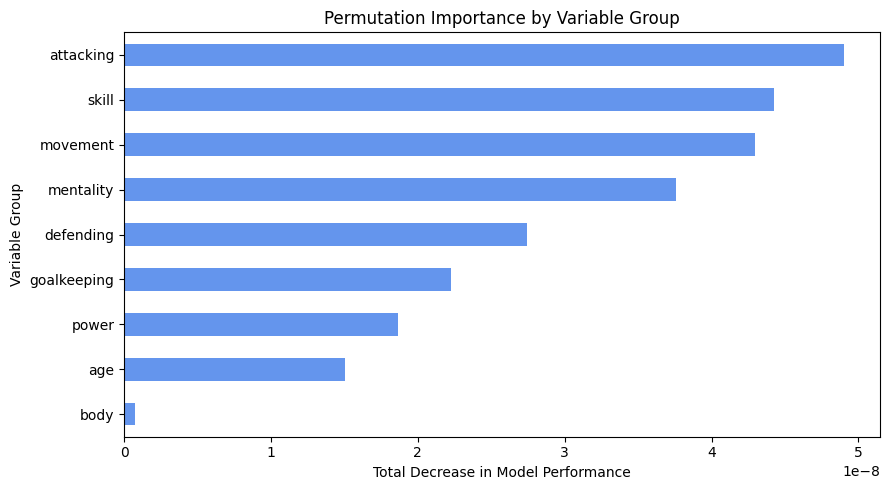

In [36]:
perm = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)
perm_importances = pd.Series(perm.importances_mean, index=X.columns)

# Agrupar por grupos
group_importance = {}
for group_name, cols in variable_groups.items():
    cols_in_data = [c for c in cols if c in perm_importances.index]
    group_importance[group_name] = perm_importances[cols_in_data].sum()

group_importance = pd.Series(group_importance).sort_values(ascending=False)

plt.figure(figsize=(9,5))
group_importance.plot(kind='barh', color='cornflowerblue')
plt.title("Permutation Importance by Variable Group")
plt.xlabel("Total Decrease in Model Performance")
plt.ylabel("Variable Group")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


>>> 

---
Ex 3. Obtain which is the variable with higher influence in Leo Messi's value. Justify which algorithm you choose

In [ ]:
messi = df[df['short_name'] == 'L. Messi'][X.columns].iloc[0]

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    mode='regression',
    random_state=42
)
messi = np.array(messi.values, dtype=float)

exp = explainer.explain_instance(
    data_row=messi,
    predict_fn=model.predict,
    num_features=10
)

exp.show_in_notebook(show_table=True)

>>> I used LIME to see the impact on the model, beacuse you can compare the impact of different variables, I tried other aproaches but LIME was the best option, age is the variable with the highest influence in Leo Messi's output value, it is a negative impact.

---
Ex 4. Explain how perturbating the `height_cm` variable affect the value of Cristiano Ronaldo

C:\Users\andre\AppData\Local\Temp\ipykernel_27216\3527120830.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ronaldo_height = float(ronaldo["height_cm"])


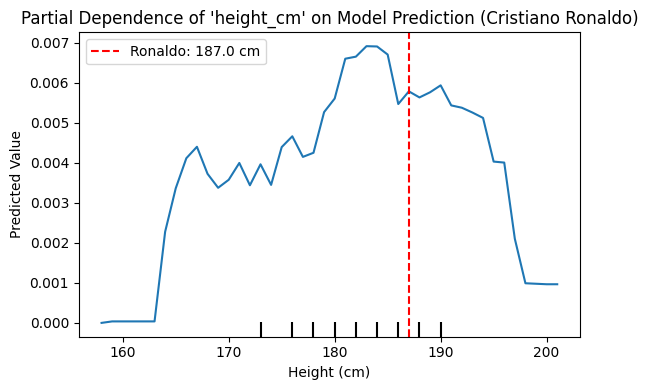

In [59]:
ronaldo = df[df["short_name"] == "Cristiano Ronaldo"][X.columns]

feature = ["height_cm"]

# Plot the partial dependence for Ronaldo
fig, ax = plt.subplots(figsize=(6, 4))
PartialDependenceDisplay.from_estimator(
    model,
    X_test,
    features=feature,
    kind="average",         
    centered=True,        
    ax=ax
)

# Optional: highlight Ronaldo's actual height
ronaldo_height = float(ronaldo["height_cm"])
plt.axvline(ronaldo_height, color="red", linestyle="--", label=f"Ronaldo: {ronaldo_height} cm")
plt.title("Partial Dependence of 'height_cm' on Model Prediction (Cristiano Ronaldo)")
plt.xlabel("Height (cm)")
plt.ylabel("Predicted Value")
plt.legend()
plt.tight_layout()
plt.show()

>>> The varibale height_cm will reduce the value when perturbating in either direction, on averge. This is mainly because the model interprets that Cristiano is a ver valuable player in that height and other player with similar height but slightly different are less valuable so it learns that at that height there is a local maximum. If the variable height_cm lowers by 2-7 cm, it results in a increase in the model prediction but ultimately it affects little to none to the model.

---
Ex 5. Explain the average effect of the `age` variable on the model predictions. Does it differ greatly along the samples in the dataset? Which should be more affected by perturbating this variable, the goalkeepers or the strikers?

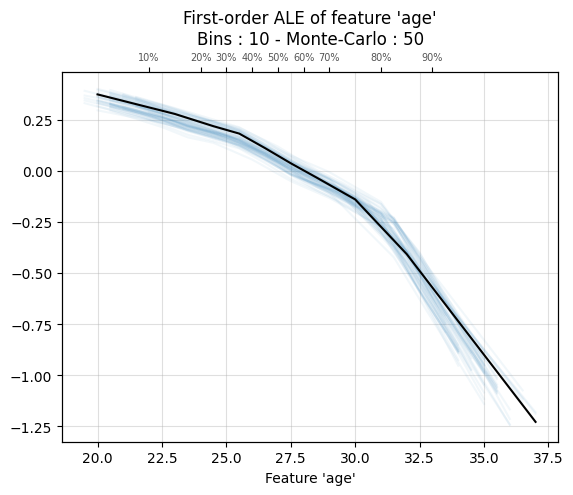

In [39]:
ale_plot(model, X_test, "age", monte_carlo=True)
plt.show()

In [40]:
X_test['ataque'] = X_test[['attacking_finishing', 'skill_dribbling', 'movement_sprint_speed']].mean(axis=1)
X_test['portero'] = X_test[['goalkeeping_diving', 'goalkeeping_reflexes', 'goalkeeping_handling']].mean(axis=1)

X_test['role'] = np.select(
    [
        X_test['portero'] > 60,          
        X_test['ataque'] > 60      
    ],
    [
        'Portero',
        'Delantero'
    ],
    default='Otro'
)

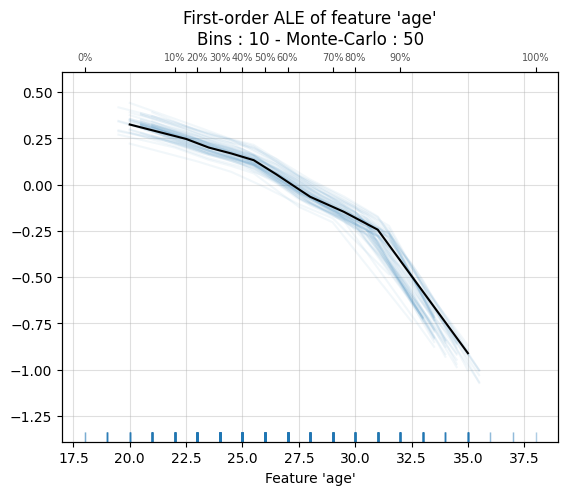

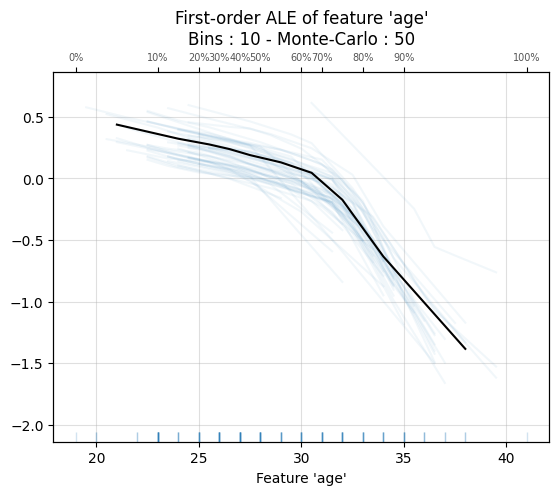

In [41]:
delanteros = X_test[X_test['role'].isin(['Delantero'])]
porteros = X_test[X_test['role'].isin(['Portero'])]

delanteros = delanteros.drop(["role", "ataque", "portero"], axis = 1)
porteros = porteros.drop(["role", "ataque", "portero"], axis = 1)

ale_plot(model, delanteros, "age", monte_carlo=True)
plt.show()
ale_plot(model, porteros, "age", monte_carlo=True)
plt.show()

X_test = X_test.drop(["role", "ataque", "portero"], axis = 1)

>>> The age affects negatively to the value, anf it doesn't differ much between players. There is a significate difference in the effect it has in golakeepers and strikers, the goalkeepers tend to start to loose value later but much faster that strikers.

---
Ex 6. Explain the prediction made for Hazard using a local surrogate model (Lime)

In [42]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    mode='regression',
    random_state=42
)


hazard_row = df.loc[df["short_name"] == "E. Hazard", X.columns].iloc[0]
hazard_row = np.array(hazard_row.values, dtype=float)

exp = explainer.explain_instance(
    data_row=hazard_row,
    predict_fn=model.predict,
    num_features=10
)

exp.show_in_notebook(show_table=True)

>>> The model predicted a high value for Hazard mainly because he has excellent movement reactions, ball control, attacking short passing, finishing, and positioning. Each of these features individually pushes the prediction upward. There were no features that significantly lowered the score.